In [1]:
import pandas as pd
import numpy as np
import pyedflib
import os
import shutil
import glob
from matplotlib import pyplot as plt

In [2]:
# Read raw PPG files

df = pd.read_csv('00000175-resteaze-sync.csv', sep=',')

In [3]:
df = df[['LedGreen','sleep_stage', 'sleep_state']].dropna()
df.head()

,LedGreen,sleep_stage,sleep_state
1,2959.0,NS,-1.0
3,2959.0,NS,-1.0
5,2957.0,NS,-1.0
7,2957.0,NS,-1.0
9,2957.0,NS,-1.0


In [4]:
df['sleep_stage'].value_counts(), df['sleep_state'].value_counts()

(N2     184346
 WK     138073
 N3     124645
 REM     83884
 N1      38064
 NS       5972
 Name: sleep_stage, dtype: int64,
  2.0    184346
  0.0    138073
  3.0    124645
  4.0     83884
  1.0     38064
 -1.0      5972
 Name: sleep_state, dtype: int64)

#### Apply band pass filter to the signal

In [5]:
from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [6]:
# apply bandpass filter

fs = 25
lowcut = 0.35
highcut = 5.0

pro_ppg = butter_bandpass_filter(df['LedGreen'], lowcut, highcut, fs, order=5)

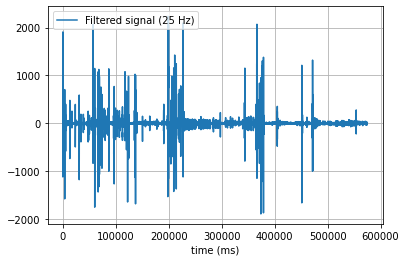

In [7]:
plt.plot(pro_ppg, label='Filtered signal (%g Hz)' % 25)
plt.xlabel('time (ms)')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

## Check EDF files for reference

In [8]:
# Read raw and annotation from EDF files
psg_fnames = glob.glob(os.path.join("./data/sleepedf/sleep-cassette", "*PSG.edf"))
ann_fnames = glob.glob(os.path.join("./data/sleepedf/sleep-cassette", "*Hypnogram.edf"))
psg_fnames.sort()
ann_fnames.sort()
psg_fnames = np.asarray(psg_fnames)
ann_fnames = np.asarray(ann_fnames)

In [9]:
i = 0

psg_f = pyedflib.EdfReader(psg_fnames[i])
ann_f = pyedflib.EdfReader(ann_fnames[i])

assert psg_f.getStartdatetime() == ann_f.getStartdatetime()
start_datetime = psg_f.getStartdatetime()

In [10]:
psg_f.getFileDuration()

79500

In [11]:
# Extract signal from the selected channel
psg_f.getSignalLabels()

['EEG Fpz-Cz',
 'EEG Pz-Oz',
 'EOG horizontal',
 'Resp oro-nasal',
 'EMG submental',
 'Temp rectal',
 'Event marker']

In [12]:
psg_f.getNSamples()

array([7950000, 7950000, 7950000,   79500,   79500,   79500,   79500])

In [13]:

sampling_rate = psg_f.getSampleFrequency(0)
n_epoch_samples = int(30 * sampling_rate)
signals = psg_f.readSignal(0).reshape(-1, n_epoch_samples)

In [14]:
signals.shape

(2650, 3000)

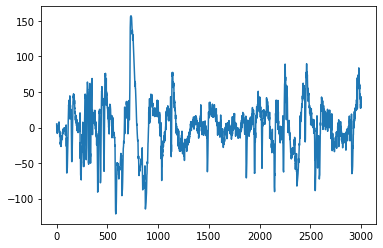

In [18]:
plt.plot(signals[0])

In [15]:

ann_onsets, ann_durations, ann_stages = ann_f.readAnnotations()

In [32]:
# Have to manually define based on the dataset
ann2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,  # Follow AASM Manual
    "Sleep stage R": 4,
    "Sleep stage ?": 6,
    "Movement time": 5
}


# Generate labels from onset and duration annotation
labels = []
total_duration = 0
ann_onsets, ann_durations, ann_stages = ann_f.readAnnotations()
for a in range(len(ann_stages)):
    onset_sec = int(ann_onsets[a])
    duration_sec = int(ann_durations[a])
    ann_str = "".join(ann_stages[a])

    # Sanity check
    assert onset_sec == total_duration

    # Get label value
    label = ann2label[ann_str]

    # Compute # of epoch for this stage
    duration_epoch = int(duration_sec / 30)

    # Generate sleep stage labels
    label_epoch = np.ones(duration_epoch, dtype=np.int) * label
    labels.append(label_epoch)

    total_duration += duration_sec

labels = np.hstack(labels)

In [39]:

# Remove annotations that are longer than the recorded signals
labels = labels[:len(signals)]


In [40]:
# Get epochs and their corresponding labels
x = signals.astype(np.float32)
y = labels.astype(np.int32)

In [44]:
from sleepstage import stage_dict

# Select only sleep periods
w_edge_mins = 30
nw_idx = np.where(y != stage_dict["W"])[0]
start_idx = nw_idx[0] - (w_edge_mins * 2)
end_idx = nw_idx[-1] + (w_edge_mins * 2)
if start_idx < 0: start_idx = 0
if end_idx >= len(y): end_idx = len(y) - 1
select_idx = np.arange(start_idx, end_idx+1)
x = x[select_idx]
y = y[select_idx]
print("Shape before movement remove", x.shape, y.shape)

# Remove movement and unknown
move_idx = np.where(y == stage_dict["MOVE"])[0]
unk_idx = np.where(y == stage_dict["UNK"])[0]
if len(move_idx) > 0 or len(unk_idx) > 0:
    remove_idx = np.union1d(move_idx, unk_idx)
    print("Remove irrelavant stages")
    print("  Movement: ({}) {}".format(len(move_idx), move_idx))
    print("  Unknown: ({}) {}".format(len(unk_idx), unk_idx))
    print("  Remove: ({}) {}".format(len(remove_idx), remove_idx))
    print("  Data before removal: {}, {}".format(x.shape, y.shape))
    select_idx = np.setdiff1d(np.arange(len(x)), remove_idx)
    x = x[select_idx]
    y = y[select_idx]
    print("  Data after removal: {}, {}".format(x.shape, y.shape))

Shape before movement remove (841, 3000) (841,)
